# Variational AutoEncoder(VAE)


* Representation Learning(표현 학습)
  * 개념 벡터(Concept Vector) : 잠재공간(Latent Space)이나 임베딩(Embedding)이 주어
  * 지면 이 공간의 어떤 방향은 원본데이터의 변화를 인코딩한 축일 수 있음.
  * 개념 벡터의 연산으로 변형된 이미지를 복원(Decoding)하여 생성 가능
* Example
  * 원통의 '높이'와 '너비'
    * 높이가 낮고 너비가 넓은 원통 이미지 생성
  * 눈의 '크기' 및 '색', 머리카락의 '길이' 및 '색'
    * 긴 검은 머리에 갈색의 큰 눈을 가진 이미지 생성
* Decoder(Generator) 학습을 위해 Encoder 사용


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# I. Load MNIST Dataset

> ## 1) X_train, X_test and y_train, y_test

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


> ## 2) Normalization and Reshape

In [ ]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

X_train.shape, X_test.shape


((60000, 784), (10000, 784))

# II. Keras Modeling with Functional API

> ## 1) 'Latent Space' Point Mapping

* 각 이미지가 '잠재공간(Lanet Space) 포인트' 주변의 '다변수 정규 분포(Multivariate Normal Distribution)'에 매핑핑

In [ ]:
from keras.layers import Input, Dense

input_img = Input(shape = (784,))

encoded = Dense(256, activation = 'elu')(input_img)
encoded = Dense(128, activation = 'elu')(encoded)


* Variational(Latent Space) Layers
  * 평균(mean)과 분산(log_var)으로 인코딩된 잠재공간(Latent Space) 포인트 분포

In [ ]:
mean = Dense(2, name = 'mean')(encoded)   # 평균

log_var = Dense(2, name = 'var')(encoded) # 분산

> ## 2) 'Latent Space' Sampling

* 잠재공간(Latent Space)의 잠재공간-포인트(z) 샘플링
  * 정규분포상에서 무작위로 선택한 'epsilon'값 사용
    * Encoding 결과값을 그대로 사용하면 항상 같은 결과만 생성
    * 따라서 랜덤 샘플링을 통하여 기존 Data에 존재하지 않는 새로운 Image 생성
* Lambda( ) : 임의의 파이썬 함수 객체를 Keras Layer로 생성
* K.exp(log_var) : 로그분산 -> 표준편차 변환


In [ ]:
from keras import backend as K
from keras.layers import Lambda

In [ ]:
def sampling(args):
  mean, log_var = args
  epsilon = K.random_normal(shape = (100, 2), mean = 0., stddev = 1.0)
  return mean + K.exp(log_var) * epsilon

z = Lambda(sampling, output_shape = (2, ))([mean, log_var])

> ## 3) 'encoder' Model

In [ ]:
from keras.models import Model

encoder = Model(input_img, mean)

In [ ]:
# encoder Model Summary
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
mean (Dense)                 (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


> ## 4) 'generator' Model

In [ ]:
# Decoding Layer Structure

decoder_1 = Dense(128, activation = 'elu')
decoder_2 = Dense(256, activation = 'elu')
decoder_3 = Dense(784, activation = 'sigmoid')


In [ ]:
# 랜덤 샘플링 '잠재공간-포인트(Z)' 재구성

z_sample = decoder_1(z)
z_sample = decoder_2(z_sample)
z_sample = decoder_3(z_sample)

In [ ]:
z_sample.shape

TensorShape([100, 784])

In [ ]:
# Generator Layers

decoder_input = Input(shape = (2,))

y_gen = decoder_1(decoder_input)
y_gen = decoder_2(y_gen)
y_gen = decoder_3(y_gen)

In [ ]:
# Build 'generator'

generator = Model(decoder_input, y_gen)

In [ ]:
# 'generator' Model Summary
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              multiple                  384       
_________________________________________________________________
dense_3 (Dense)              multiple                  33024     
_________________________________________________________________
dense_4 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


# III. VAE Fit

> ## 1) 'vae' Model Define

* Build 'vae' Model
  * End-to-End AutoEncoder

In [ ]:
vae = Model(input_img, z_sample)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

> ## 2) Model Compile

* Define 'vae_loss'
  * reconstruction_loss: 입력값 재구성 손실
    * 원본 이미지워 생성된 이미지와의 오차(CEE)
    * '샘플링 함수'로 생성한 'z'값으로 얼마나 원본이미지와 유사한 이미지를 잘 생성 하는가?

  * kl_loss: 사전 분포와 잠재 분포 사이의 Kullback Leibler-Divergence(두 확률분포 간 거리)
    * 사전 분포(Prior Distribution): 원본 이미지 확률분포
    * 잠재 분포( Latent Distribution): 잠재공간 확률분포
    * '샘플링 함수'의 값이 원본 이미지의 확률분포와 유사한가?
* 추가 설명

In [ ]:
from keras import objectives

reconstruction_loss = objectives.binary_crossentropy(input_img, z_sample)
kl_loss = 0.0005 * K.mean(K.square(mean) + K.exp(log_var) - log_var - 1, axis = -1) # 0.0005는 조절 가능

vae_loss = reconstruction_loss + kl_loss


In [ ]:
# Add vae_loss

vae.add_loss(vae_loss)

In [ ]:
# Compile with vae_loss

vae.compile(optimizer = 'adam')

> ## 3) Model Training

In [ ]:
%%time

vae.fit(X_train,
       shuffle = True,
       epochs = 300,
       batch_size = 100,
       validation_data = (X_test, None))


Epoch 1/300
600/600 [==============================] - 8s 13ms/step - loss: 0.2773 - val_loss: 0.2181
Epoch 2/300
600/600 [==============================] - 7s 12ms/step - loss: 0.2156 - val_loss: 0.2063
Epoch 3/300
600/600 [==============================] - 7s 12ms/step - loss: 0.2052 - val_loss: 0.1999
Epoch 4/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1989 - val_loss: 0.1940
Epoch 5/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1933 - val_loss: 0.1908
Epoch 6/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1901 - val_loss: 0.1890
Epoch 7/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1886 - val_loss: 0.1873
Epoch 8/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1875 - val_loss: 0.1863
Epoch 9/300
600/600 [==============================] - 7s 12ms/step - loss: 0.1858 - val_loss: 0.1851
Epoch 10/300
600/600 [==============================] - 7s 12ms/step - loss: 0.184

# IV. 'Latent Space' Visualization

> ## 1) Classes in the Latent Space

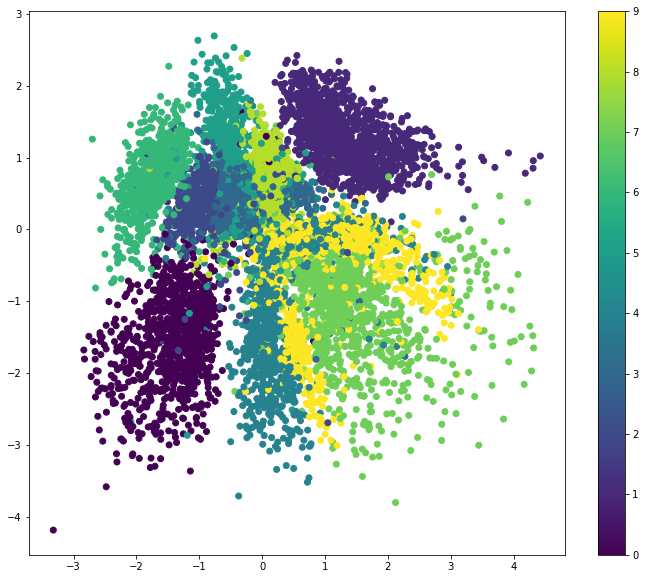

In [ ]:
X_test_latent = encoder.predict(X_test, batch_size = 100)

plt.figure(figsize = (12, 10))
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c = y_test)
plt.colorbar()
plt.show()


> ## 2) Display 2D Manifold(20*20)

* 두 개의 '개념 벡터(Concept Vector)'로 데이터의 특징을 '표현(Representation)'
  * 두계, 회전각도 등

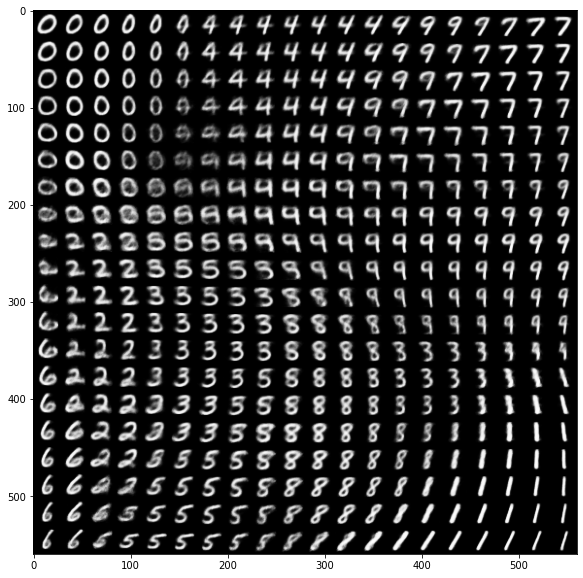

In [ ]:
from scipy.stats import norm

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
               
plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()



# V. 'generator' Test

> ## 1) 'encoder' Test (784 -> 2)

In [ ]:
encoded_latent = encoder.predict(X_test)

encoded_latent.shape

(10000, 2)

> ## 2) 'generator' Test (2 -> 784)

In [ ]:
generated_imgs = generator.predict(encoded_latent)

generated_imgs.shape

(10000, 784)

> ## 3) Generating Visualization

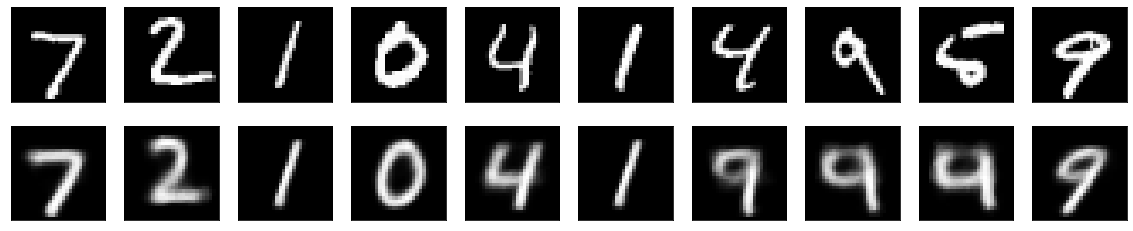

In [ ]:
# 복원이 아닌 생성된 이미지들

n = 10

plt.figure(figsize = (20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generated_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()